In [26]:
import matplotlib.pyplot as plt
import numpy as np
from joblib import Parallel, delayed

import acoustotreams

k0 =  2 * np.pi * 50000 / 343
materials = [acoustotreams.AcousticMaterial(1050, 4350), 
            acoustotreams.AcousticMaterial(998, 1497)]
lmax = 3
radii = [0.0075, 0.0075]
positions = [[-0.004, 0, -0.0075], [0.004, 0, 0.0075]]
period = 0.035
lattice = acoustotreams.Lattice.square(period)
kpar = [0, 0]

In [27]:
spheres = [acoustotreams.AcousticTMatrix.sphere(lmax, k0, r, materials) for r in radii]
tm = acoustotreams.AcousticTMatrix.cluster(spheres, positions).latticeinteraction.solve(
    lattice, kpar
    )

In [28]:
inc = acoustotreams.plane_wave_scalar([0, 0, tm.k0], k0=tm.k0, material=tm.material)
sca = tm.sca(inc)

In [29]:
x = np.linspace(-0.5*period, 0.5*period, 101)
z = np.linspace(-0.5*period, 0.5*period, 101)
def compute_intensity(i, j, tm, radii, inc, sca):
    r = [x[j], 0, z[i]]  
    if tm.valid_points(r, radii):
        swb = acoustotreams.ScalarSphericalWaveBasis.default(0, positions=[r])
        field = sca.expandlattice(basis=swb).pfield(r) 
        result = np.real(inc.pfield(r) + field)  
    else:
        result = np.nan
    return i, j, result  
results = Parallel(n_jobs=-1)(
    delayed(compute_intensity)(i, j, tm, radii, inc, sca) 
    for i in range(len(z)) 
    for j in range(len(x))
)
intensity = np.zeros((len(z), len(x)))
for i, j, result in results:
    intensity[i, j] = result

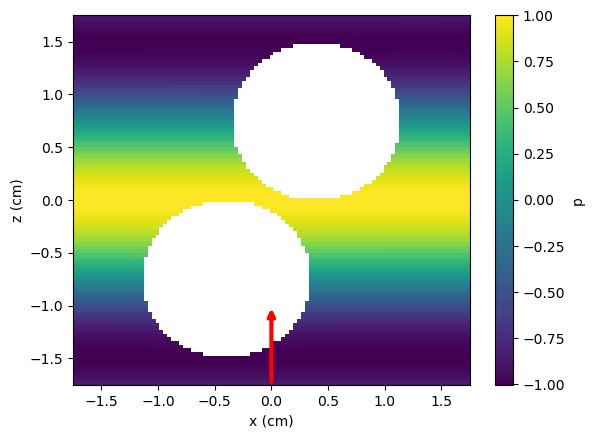

In [30]:
fig, ax = plt.subplots()
cax = ax.imshow(
    intensity,
    extent = [x.min() * 100, x.max() * 100, z.min() * 100, z.max() * 100],
    aspect='auto',
    origin='lower',
)
cb = plt.colorbar(cax)
cb.set_label("p")
ax.set_xlabel("x (cm)")
ax.set_ylabel("z (cm)")
ax.annotate(
    "", 
    xy=(0, -1.0),
    xytext=(0, -1.75), 
    arrowprops=dict(
        arrowstyle="->",
        lw=3, 
        color="red" 
    )
)
plt.show()